# A Totural on Binary Estimation 

In this notebook we are going to estimate weights (coefficients) of a linear regression model as binary values. Different scenarios with different methods such as least square, rounding, binary penalty term, and $L_1$ regularisation have been checked.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate

# Scenario No. 1: A dataset with binary weights

In the first scenario a dataset with $n_features=10$ features and $n_samples$ sample has been considered. Dataset is generated over a normal distribution with $\mu=0$ and $\sigma^2=1$ or
$X \sim \mathcal{N}(\mu, \sigma^2)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta+\epsilon \\
\epsilon &\sim \mathcal{N}(\mu, \sigma^2)
\end{align*}

$\beta$ is a vector of 0 and 1: $\beta_i \in \{1,0\}, \beta = \{\beta_i | i=1,..,n_{features}\}$

# Data Generating

In [2]:
RNG = np.random.default_rng(seed=1)
n_features = 10
n_samples = 50
var = 1
cov = var*np.eye(n_features)
mean = np.zeros(n_features)
sigma = 1

# To define the weights as beta
beta = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1])

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n_samples)
y = x@beta + RNG.normal(0, sigma**2, size=n_samples)

# Least Square Estimation

In [3]:
def leastsquare(x, y):
    return np.linalg.solve(x.T.dot(x), x.T.dot(y))

# Optimizer

In [4]:
# optimisation algorithm
def minimizer(lossfunction, alpha, x, y, n_features):   
    initial_beta = np.random.randint(2,size=(n_features))
    result = minimize(lossfunction, initial_beta, method='Powell', args=(alpha, x, y, n_features), tol=1e-8)
    optimized_beta = result.x
    return optimized_beta

# Sparsity: L1 Regularization Estimation

In [5]:
# criterion definition
def squared_error(beta, x, y, d):  ## Sum of abs residuals (norm 1)
    beta = np.reshape(beta,(-1, d))
    return np.sum(abs(beta@x.T-y)**2,axis=1)

def L1_lossfunc(beta, alpha, x, y, n_features):
    return squared_error(beta, x, y, n_features) + alpha*np.sum(abs(np.reshape(beta,(-1,n_features))),axis=1)

# Sparsity: Binary Estimation

In [6]:
# criterion definition
def binary_lossfunc(beta, alpha , x, y, n_features):
  pp = []
  beta = np.reshape(beta,(-1, n_features))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<=0.5:
        p.append(alpha*abs(b))
      else:
        p.append(alpha*abs(b-1))
    pp.append(np.sum(p))
  return squared_error(beta,x , y, n_features)+np.asarray(pp)

In [7]:
def binary_round(v):
    v = np.asarray(v)
    bv = []
    for x in v:
        if abs(x) < abs(x-1):
            x = 0
        elif abs(x-1) < abs(x):
            x = 1
        else:
            x = x
        bv.append(x)
    return bv

# Sample Size Effect

In [8]:
class Resampling:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            train_idx = self.RNG.choice(np.arange(len(x)), size=round(self.train_size*len(x)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

In [9]:
# def resampling_optimizer(reps, x, y, lossfunc, optimizer, alpha):
#     beta_hat = []
#     beta_estimation_error_per_repetation = []
#     std_error_per_samplesize = []
#     mean_error_per_samplesize = []
#     repetation = reps
#     n_samples, n_features = x.shape
#     if n_samples<10:
#         training_size = [n_samples]
#     else:
#         training_size = np.array(range(1,11))*np.divide(n_samples, 10).astype(np.int16)

#     for n in training_size:
#         for r in range(repetation):
#             sample_index = np.random.choice(len(x), n, replace=False)
#             sample_size = n
#             x_input = x[sample_index]
#             y_label = y[sample_index]
#             beta_hat.append(optimizer(lossfunc, alpha, x_input, y_label, n_features))
#             beta_estimation_error_per_repetation.append(np.sum((beta-beta_hat[-1])**2))
#         mean_error_per_samplesize.append(np.mean(beta_estimation_error_per_repetation))
#         std_error_per_samplesize.append(np.std(beta_estimation_error_per_repetation))

#     return np.array(mean_error_per_samplesize), np.array(std_error_per_samplesize), training_size

In [19]:
repetition = 100
alpha = 1.5

binary_beta_hat_mean_error = []
binary_beta_hat_std_error = []
l1_beta_hat_std_error, l1_beta_hat_mean_error , l1_mean_train_error_per_samplesize, l1_std_train_error_per_samplesize, l1_mean_test_error_per_samplesize, l1_std_test_error_per_samplesize =  [], [], [],[],[],[]
ls_beta_hat_mean_error, ls_beta_hat_std_error, ls_mean_train_error_per_samplesize,ls_std_train_error_per_samplesize, ls_mean_test_error_per_samplesize,ls_std_test_error_per_samplesize= [], [], [],[],[],[]
binary_beta_hat_std_error, binary_beta_hat_mean_error, binary_mean_train_error_per_samplesize, binary_std_train_error_per_samplesize, binary_mean_test_error_per_samplesize, binary_std_test_error_per_samplesize = [], [], [],[],[],[]
rls_beta_hat_mean_error, rls_beta_hat_std_error, rls_mean_train_error_per_samplesize, rls_std_train_error_per_samplesize, rls_mean_test_error_per_samplesize, rls_std_test_error_per_samplesize = [], [], [],[],[],[]

# training_size = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sample_size = np.linspace(0.3,1,12)
sample_size = np.round(len(x)*np.array(sample_size)).astype(int)


for ss in sample_size:
    sample_id = RNG.choice(np.arange(len(x)), size=ss, replace=False)
    x_sample = x[sample_id]
    y_sample = y[sample_id]
    res = Resampling(repetition, 0.9, random_state=0)
    splitted_data = res.split(x_sample, y_sample)
    l1_beta_hat, l1_sse_train_error, l1_sse_test_error, rl1_beta_hat = [], [], [], []
    binary_beta_hat, binary_sse_train_error, binary_sse_test_error, rbinary_beta_hat = [], [], [], []
    ls_beta_hat, ls_sse_train_error, ls_sse_test_error = [], [], []
    rls_beta_hat, rls_sse_train_error, rls_sse_test_error = [], [], []
    

    for train_idx, test_idx in splitted_data:

        l1_beta_hat.append(minimizer(L1_lossfunc, alpha, x_sample[train_idx], y_sample[train_idx], x_sample.shape[1]))
        rl1_beta_hat.append(binary_round(l1_beta_hat[-1]))
        l1_sse_train_error.append(squared_error(rl1_beta_hat[-1], x_sample[train_idx], y_sample[train_idx], x_sample.shape[1]))
        l1_sse_test_error.append(squared_error(rl1_beta_hat[-1], x_sample[test_idx], y_sample[test_idx], x_sample.shape[1]))

        binary_beta_hat.append(minimizer(binary_lossfunc, alpha, x_sample[train_idx], y_sample[train_idx], x_sample.shape[1]))
        rbinary_beta_hat.append(binary_round(binary_beta_hat[-1]))
        binary_sse_train_error.append(squared_error(rbinary_beta_hat[-1], x_sample[train_idx], y_sample[train_idx], x_sample.shape[1]))
        binary_sse_test_error.append(squared_error(rbinary_beta_hat[-1], x_sample[test_idx], y_sample[test_idx], x_sample.shape[1]))

        ls_beta_hat.append(leastsquare(x_sample[train_idx],y_sample[train_idx]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], x_sample[train_idx], y_sample[train_idx], x_sample.shape[1]))
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], x_sample[test_idx], y_sample[test_idx], x_sample.shape[1]))
        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        rls_sse_train_error.append(squared_error(rls_beta_hat[-1], x_sample[train_idx], y_sample[train_idx], x_sample.shape[1]))
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], x_sample[test_idx], y_sample[test_idx], x_sample.shape[1]))

        
    l1_beta_hat_mean_error.append(np.mean(np.sum((beta-rl1_beta_hat)**2, axis=1)))
    l1_beta_hat_std_error.append(np.std(np.sum((beta-rl1_beta_hat)**2, axis=1)))
    l1_mean_train_error_per_samplesize.append(np.mean(l1_sse_train_error)/ss)
    l1_std_train_error_per_samplesize.append(np.std(l1_sse_train_error)/ss)
    l1_mean_test_error_per_samplesize.append(np.mean(l1_sse_test_error)/ss)
    l1_std_test_error_per_samplesize.append(np.std(l1_sse_test_error)/ss)

    binary_beta_hat_mean_error.append(np.mean(np.sum((beta-rbinary_beta_hat)**2, axis=1)))
    binary_beta_hat_std_error.append(np.std(np.sum((beta-rbinary_beta_hat)**2, axis=1)))
    binary_mean_train_error_per_samplesize.append(np.mean(binary_sse_train_error)/ss)
    binary_std_train_error_per_samplesize.append(np.std(binary_sse_train_error)/ss)
    binary_mean_test_error_per_samplesize.append(np.mean(binary_sse_test_error)/ss)
    binary_std_test_error_per_samplesize.append(np.std(binary_sse_test_error)/ss)

    ls_beta_hat_mean_error.append(np.mean(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_beta_hat_std_error.append(np.std(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_mean_train_error_per_samplesize.append(np.mean(ls_sse_train_error)/ss)
    ls_std_train_error_per_samplesize.append(np.std(ls_sse_train_error)/ss)
    ls_mean_test_error_per_samplesize.append(np.mean(ls_sse_test_error)/ss)
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error)/ss)

    rls_beta_hat_mean_error.append(np.mean(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_std_error.append(np.std(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_mean_train_error_per_samplesize.append(np.mean(rls_sse_train_error)/ss)
    rls_std_train_error_per_samplesize.append(np.std(rls_sse_train_error)/ss)
    rls_mean_test_error_per_samplesize.append(np.mean(rls_sse_test_error)/ss)
    rls_std_test_error_per_samplesize.append(np.std(rls_sse_test_error)/ss)


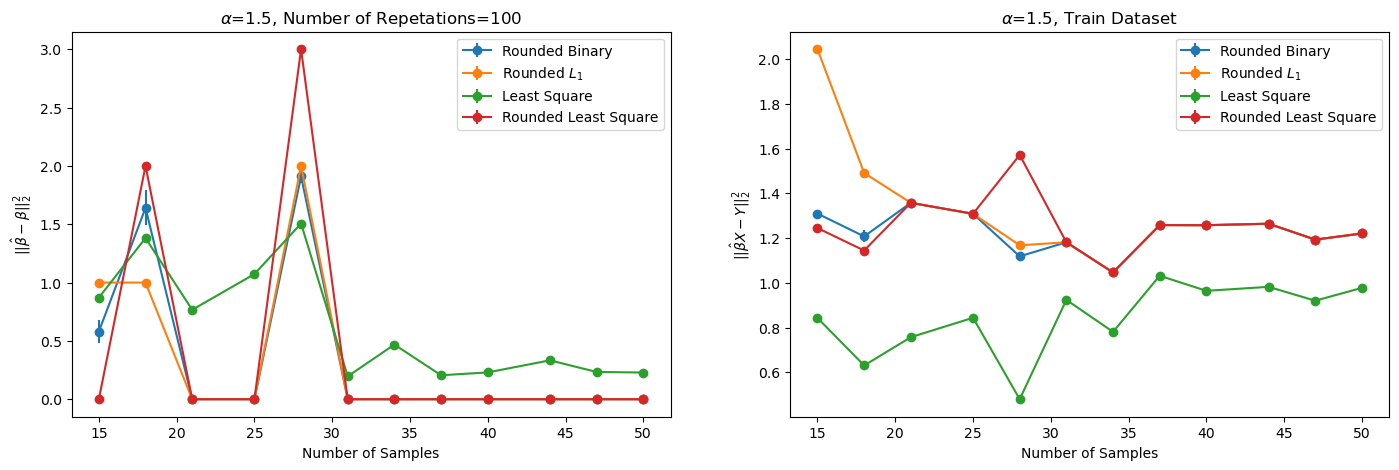

In [18]:
_, axs = plt.subplots(1, 2, figsize=(17, 5))
axs[0].errorbar(sample_size, binary_beta_hat_mean_error, yerr=np.array(binary_beta_hat_std_error)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, l1_beta_hat_mean_error, yerr=np.array(l1_beta_hat_std_error)*1.96/(repetition**0.5), marker='o',  label='Rounded $L_1$')
axs[0].errorbar(sample_size, ls_beta_hat_mean_error, yerr=np.array(ls_beta_hat_std_error)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs[0].errorbar(sample_size, rls_beta_hat_mean_error, yerr=np.array(rls_beta_hat_std_error)*1.96/(repetition**0.5), marker='o',  label='Rounded Least Square')
axs[0].set_xlabel('Number of Samples')
axs[0].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
axs[0].set_title(f'$\\alpha$={alpha}, Number of Repetations={repetition}')
axs[0].legend()

axs[1].errorbar(sample_size, binary_mean_train_error_per_samplesize, yerr=np.array(binary_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[1].errorbar(sample_size, l1_mean_train_error_per_samplesize, yerr=np.array(l1_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Rounded $L_1$')
axs[1].errorbar(sample_size, ls_mean_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, rls_mean_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[1].set_xlabel('Number of Samples')
axs[1].set_ylabel('$||\\hat{\\beta}X-Y||_{2}^{2}$')
axs[1].set_title(f'$\\alpha$={alpha}, Train Dataset')
axs[1].legend()

# axs[2].errorbar(sample_size, binary_mean_test_error_per_samplesize, yerr=np.array(binary_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
# axs[2].errorbar(sample_size, l1_mean_test_error_per_samplesize, yerr=np.array(l1_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded $L_1$')
# axs[2].errorbar(sample_size, ls_mean_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Least Square')
# axs[2].errorbar(sample_size, rls_mean_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
# axs[2].set_xlabel('Number of Samples')
# axs[2].set_ylabel('$||\\hat{\\beta}X-Y||_{2}^{2}$')
# axs[2].set_title(f'$\\alpha$={alpha}, Test Dataset')
# axs[2].legend()

In [ ]:
alpha_range = [0.1, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]
l1_beta_hat_per_fold, l1_rounded_beta_hat_per_fold, l1_sse_valid_per_fold = [], [], []
binary_beta_hat_per_fold,  binary_rounded_beta_hat_per_fold, binary_sse_valid_per_fold = [], [], []

l1_mean_sse_valid_per_alpha, l1_beta_hat_mean_error_per_alpha, l1_beta_hat_std_error_per_alpha = [], [], []
binary_mean_sse_valid_per_alpha, binary_beta_hat_mean_error_per_alpha, binary_beta_hat_std_error_per_alpha = [], [], []

kf = KFold(n_splits=10, shuffle=True, random_state=529)
for a in alpha_range:
    for train_ind, val_ind in kf.split(x,y):

        l1_beta_hat_per_fold.append(minimizer(L1_lossfunc, a, x[train_ind], y[train_ind], x.shape[1]))
        l1_rounded_beta_hat_per_fold.append(binary_round(l1_beta_hat_per_fold[-1]))
        l1_sse_valid_per_fold.append(squared_error(l1_rounded_beta_hat_per_fold[-1], x[val_ind], y[val_ind], n_features))
    
        binary_beta_hat_per_fold.append(minimizer(binary_lossfunc, a, x[train_ind], y[train_ind], x.shape[1]))
        binary_rounded_beta_hat_per_fold.append(binary_round(binary_beta_hat_per_fold[-1]))
        binary_sse_valid_per_fold.append(squared_error(binary_rounded_beta_hat_per_fold[-1], x[val_ind], y[val_ind], n_features))
        
    l1_mean_sse_valid_per_alpha.append(np.mean(l1_sse_valid_per_fold))
    l1_beta_hat_mean_error_per_alpha.append(np.mean(np.sum((beta-l1_rounded_beta_hat_per_fold)**2, axis=1)))
    l1_beta_hat_std_error_per_alpha.append(np.std(np.sum((beta-l1_rounded_beta_hat_per_fold)**2, axis=1)))
    binary_mean_sse_valid_per_alpha.append(np.mean(binary_sse_valid_per_fold))
    binary_beta_hat_mean_error_per_alpha.append(np.mean(np.sum((beta-binary_rounded_beta_hat_per_fold)**2, axis=1)))
    binary_beta_hat_std_error_per_alpha.append(np.std(np.sum((beta-binary_rounded_beta_hat_per_fold)**2, axis=1)))

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(alpha_range, binary_mean_sse_valid_per_alpha, marker='o', color='red', label='Binary Penalty')
axs[0].plot(alpha_range, l1_mean_sse_valid_per_alpha, marker='o', color='blue', label='$L_1$ Reg.')
axs[0].set_xlabel('$\\alpha$')
axs[0].set_ylabel('Mean Squared Error over Validation Data')
axs[0].set_title('With Rounding the Weights to 0 & 1')
axs[0].legend()

axs[1].errorbar(alpha_range, binary_beta_hat_mean_error_per_alpha, yerr=np.array(binary_beta_hat_std_error_per_alpha)*1.96/(10**0.5), marker='o', color = 'red', label='Binary Penalty')
axs[1].errorbar(alpha_range, l1_beta_hat_mean_error_per_alpha, yerr=np.array(l1_beta_hat_std_error_per_alpha)*1.96/(10**0.5), marker='o', color = 'blue', label='$L_1$ Reg.')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
axs[1].set_title('With Rounding the Weights to 0 & 1')
axs[1].legend()

# Scenario No. 2: Least Square vs. Rounded Least Square for a Binary Structure

In [ ]:
repetition = 1000
# sample_size = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] #percent
sample_size = np.linspace(0.3,1,35)
sample_size = np.round(len(x)*np.array(sample_size)).astype(int)
ls_beta_hat_mean_error_per_samplesize, ls_beta_hat_std_error_per_samplesize, ls_sse_train_error_per_samplesize, ls_sse_test_error_per_samplesize = [], [], [], []
rls_beta_hat_mean_error_per_samplesize, rls_beta_hat_std_error_per_samplesize, rls_sse_train_error_per_samplesize, rls_sse_test_error_per_samplesize = [], [], [], []
ls_std_test_error_per_samplesize, rls_std_test_error_per_samplesize = [], []

for ss in sample_size:
    sample_id = RNG.choice(np.arange(len(x)), size=ss, replace=False)
    x_sample = x[sample_id]
    y_sample = y[sample_id]
    ls_beta_hat = []
    rls_beta_hat = []
    ls_sse_train_error = []
    ls_sse_test_error = []
    rls_sse_train_error = []
    rls_sse_test_error = []

    res = Resampling(repetition, 0.8, random_state=0)
    for train_id, test_id in res.split(x_sample):
        ls_beta_hat.append(leastsquare(x_sample[train_id], y_sample[train_id]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1])/ss)
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1])/ss)

        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        # rls_sse_train_error.append(squared_error(rls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1])/ss)
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1])/ss)



    ls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_sse_train_error_per_samplesize.append(np.mean(ls_sse_train_error))
    ls_sse_test_error_per_samplesize.append(np.mean(ls_sse_test_error))
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error))

    rls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-rls_beta_hat)**2, axis=1)))
    # rls_sse_train_error_per_samplesize.append(np.mean(rls_sse_train_error))
    rls_sse_test_error_per_samplesize.append(np.mean(rls_sse_test_error))
    rls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
pn=1
axs[0].errorbar(sample_size[pn:], ls_beta_hat_mean_error_per_samplesize[pn:], yerr=np.array(ls_beta_hat_std_error_per_samplesize[pn:])*1.96/(repetition**0.5), marker='o', color = 'red', label='Least Squared')
axs[0].errorbar(sample_size[pn:], rls_beta_hat_mean_error_per_samplesize[pn:], yerr=np.array(rls_beta_hat_std_error_per_samplesize[pn:])*1.96/(repetition**0.5), marker='o', color='blue', label='Rounded Least Squared')
axs[0].set_xlabel('Number of Samples')
axs[0].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
# axs[0].set_title('With Binary Weights')
axs[0].legend()

# axs[1].plot(sample_size, ls_sse_test_error_per_samplesize, marker='o', color = 'red', label='Least Squared')
# axs[1].plot(sample_size, rls_sse_test_error_per_samplesize, marker='o', color='blue', label='Rounded Least Squared')
axs[1].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color = 'red', label='Least Squared')
axs[1].errorbar(sample_size, rls_sse_test_error_per_samplesize,yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color='blue', label='Rounded Least Squared')
axs[1].set_xlabel('Number of Samples')
axs[1].set_ylabel('Sum Squared Error over Test Data')
# axs[1].set_title('With Binary Weights')
axs[1].legend()

fig.suptitle('$\\beta_i \in \{0,1\}$')

# Scenario No. 3: A dataset with non-binary weights

In this scenario, the database is generated same as before with $n_{features}=10$ from a normal distribution $X \sim \mathcal{N}(\mu_1=0, \sigma_1^2=1)$ but $\beta$ is a vector of non-binary values from $\beta \sim \mathcal{N}(\mu_2=0, \sigma_2^2=2)$. Now we are going to find the best binary approximation for $\beta$ that minimizes the loss function.

In [ ]:
n_features = 10
n_samples = 100
var = 1
cov = var*np.eye(n_features)
mean = np.zeros(n_features)
sigma = 1
RNG = np.random.default_rng(seed=1)
# To define the weights as beta

beta = np.squeeze(RNG.multivariate_normal(np.zeros(1), 2*np.eye(1), size=n_features))

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n_samples)

# x0 = np.reshape(np.ones(n_samples), (-1,1))
# x = np.concatenate((x0,x_origin), axis=1)

y = x@beta + RNG.normal(0, sigma**2, size=n_samples)

In [ ]:
repetition = 10000
# sample_size = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1] #percent
sample_size = np.linspace(0.3,1,35)
sample_size = np.round(len(x)*np.array(sample_size)).astype(int)
ls_beta_hat_mean_error_per_samplesize, ls_beta_hat_std_error_per_samplesize, ls_sse_train_error_per_samplesize, ls_sse_test_error_per_samplesize = [], [], [], []
rls_beta_hat_mean_error_per_samplesize, rls_beta_hat_std_error_per_samplesize, rls_sse_train_error_per_samplesize, rls_sse_test_error_per_samplesize = [], [], [], []
ls_std_train_error_per_samplesize, ls_std_test_error_per_samplesize = [], []
rls_std_test_error_per_samplesize, rls_std_train_error_per_samplesize = [], []
for ss in sample_size:
    sample_id = RNG.choice(np.arange(len(x)), size=ss, replace=False)
    x_sample = x[sample_id]
    y_sample = y[sample_id]
    ls_beta_hat = []
    rls_beta_hat = []
    ls_sse_train_error = []
    ls_sse_test_error = []
    rls_sse_train_error = []
    rls_sse_test_error = []

    res = Resampling(repetition, 0.8, random_state=0)
    for train_id, test_id in res.split(x_sample):
        ls_beta_hat.append(leastsquare(x_sample[train_id], y_sample[train_id]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        rls_sse_train_error.append(squared_error(rls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))


    # ls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-ls_beta_hat)**2, axis=1)))
    # ls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_sse_train_error_per_samplesize.append(np.mean(ls_sse_train_error)/ss)
    ls_std_train_error_per_samplesize.append(np.std(ls_sse_train_error))
    ls_sse_test_error_per_samplesize.append(np.mean(ls_sse_test_error)/ss)
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error))

    # rls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-rls_beta_hat)**2, axis=1)))
    # rls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_sse_train_error_per_samplesize.append(np.mean(rls_sse_train_error)/ss)
    rls_std_train_error_per_samplesize.append(np.std(rls_sse_train_error))
    rls_sse_test_error_per_samplesize.append(np.mean(rls_sse_test_error)/ss)
    rls_std_test_error_per_samplesize.append(np.std(rls_sse_test_error))

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

axs[0,0].errorbar(sample_size, ls_sse_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color = 'red', label='Train')
axs[0,0].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color='blue', label='Test')
# axs[0,0].set_xlabel('Number of Samples')
axs[0,0].set_ylabel('SSE')
axs[0,0].set_title(f'Least Square')
axs[0,0].legend()

axs[0,1].errorbar(sample_size, rls_sse_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color = 'red', label='Train')
axs[0,1].errorbar(sample_size, rls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color='blue', label='Test')
# axs[0,1].set_xlabel('Number of Samples')
# axs[0,1].set_ylabel('SSE')
axs[0,1].set_title(f'Rounded Least Square')
axs[0,1].legend()

axs[1,0].errorbar(sample_size, ls_sse_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color = 'blue', label='Least Square')
axs[1,0].errorbar(sample_size, rls_sse_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color = 'red', label='Rounded Least Square')
axs[1,0].set_xlabel('Number of Samples')
axs[1,0].set_ylabel('SSE')
axs[1,0].set_title(f'Train Dataset')
axs[1,0].legend()

axs[1,1].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color='blue', label='Least Square')
axs[1,1].errorbar(sample_size, rls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', color='red', label='Rounded Least Square')
axs[1,1].set_xlabel('Number of Samples')
# axs[1,1].set_ylabel('SSE')
axs[1,1].set_title(f'Test Dataset')
axs[1,1].legend()

fig.suptitle('$\\beta_i \in \{0,1 \}$')

# Scenario No. 4: A dataset with non-binary weights and penalty term

In [ ]:
repetition = 50
# sample_size = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1] #percent
sample_size = np.linspace(0.3,1,35)
sample_size = np.round(len(x)*np.array(sample_size)).astype(int)
ls_beta_hat_mean_error_per_samplesize, ls_beta_hat_std_error_per_samplesize, ls_sse_train_error_per_samplesize, ls_sse_test_error_per_samplesize = [], [], [], []
ls_std_train_error_per_samplesize, ls_std_test_error_per_samplesize = [], []

rls_beta_hat_mean_error_per_samplesize, rls_beta_hat_std_error_per_samplesize, rls_sse_train_error_per_samplesize, rls_sse_test_error_per_samplesize = [], [], [], []
rls_std_train_error_per_samplesize, rls_std_test_error_per_samplesize = [], []

l1_beta_hat_mean_error_per_samplesize, l1_beta_hat_std_error_per_samplesize, l1_sse_train_error_per_samplesize, l1_std_train_error_per_samplesize = [], [], [], []
l1_sse_test_error_per_samplesize, l1_std_test_error_per_samplesize = [], []

binary_beta_hat_mean_error_per_samplesize,binary_beta_hat_std_error_per_samplesize,binary_sse_train_error_per_samplesize,binary_std_train_error_per_samplesize,binary_sse_test_error_per_samplesize,binary_std_test_error_per_samplesize = [], [], [], [], [],[]

for ss in sample_size:
    sample_id = RNG.choice(np.arange(len(x)), size=ss, replace=False)
    x_sample = x[sample_id]
    y_sample = y[sample_id]
    ls_beta_hat = []
    l1_beta_hat = []
    rls_beta_hat = []

    ls_sse_train_error = []
    ls_sse_test_error = []
    rls_sse_train_error = []
    rls_sse_test_error = []
    l1_sse_train_error = []
    l1_sse_test_error = []
    binary_sse_train_error = []
    binary_sse_test_error = []

    res = Resampling(repetition, 0.8, random_state=0)
    for train_id, test_id in res.split(x_sample):
        ls_beta_hat.append(leastsquare(x_sample[train_id], y_sample[train_id]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        rls_sse_train_error.append(squared_error(rls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

        l1_beta_hat.append(minimizer(L1_lossfunc, alpha=1.5, x=x_sample[train_id], y=y_sample[train_id], n_features=x.shape[1]))
        rl1_beta_hat.append(binary_round(l1_beta_hat[-1]))
        l1_sse_train_error.append(squared_error(rl1_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        l1_sse_test_error.append(squared_error(rl1_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

        binary_beta_hat.append(binary_round(minimizer(binary_lossfunc, alpha=1.5, x=x_sample[train_id], y=y_sample[train_id], n_features=x.shape[1])))
        # binary_beta_hat.append(binary_round(binary_beta_hat[-1]))
        binary_sse_train_error.append(squared_error(binary_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        binary_sse_test_error.append(squared_error(binary_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

    ls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_sse_train_error_per_samplesize.append(np.mean(ls_sse_train_error)/ss)
    ls_std_train_error_per_samplesize.append(np.std(ls_sse_train_error)/ss)
    ls_sse_test_error_per_samplesize.append(np.mean(ls_sse_test_error)/ss)
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error)/ss)

    rls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_sse_train_error_per_samplesize.append(np.mean(rls_sse_train_error)/ss)
    rls_std_train_error_per_samplesize.append(np.std(rls_sse_train_error)/ss)
    rls_sse_test_error_per_samplesize.append(np.mean(rls_sse_test_error)/ss)
    rls_std_test_error_per_samplesize.append(np.std(rls_sse_test_error)/ss)



    l1_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-rl1_beta_hat)**2, axis=1)))
    l1_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-rl1_beta_hat)**2, axis=1)))
    l1_sse_train_error_per_samplesize.append(np.mean(l1_sse_train_error)/ss)
    l1_std_train_error_per_samplesize.append(np.std(l1_sse_train_error)/ss)
    l1_sse_test_error_per_samplesize.append(np.mean(l1_sse_test_error)/ss)
    l1_std_test_error_per_samplesize.append(np.std(l1_sse_test_error)/ss)

    binary_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-binary_beta_hat)**2, axis=1)))
    binary_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-binary_beta_hat)**2, axis=1)))
    binary_sse_train_error_per_samplesize.append(np.mean(binary_sse_train_error)/ss)
    binary_std_train_error_per_samplesize.append(np.std(binary_sse_train_error)/ss)
    binary_sse_test_error_per_samplesize.append(np.mean(binary_sse_test_error)/ss)
    binary_std_test_error_per_samplesize.append(np.std(binary_sse_test_error)/ss)



In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
axs[0].errorbar(sample_size, ls_sse_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Train')
axs[0].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Test')
axs[0].set_xlabel('Number of Samples')
axs[0].set_ylabel('SSE')
axs[0].set_title('Least Square')
axs[0].legend()

axs[1].errorbar(sample_size, rls_sse_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Train')
axs[1].errorbar(sample_size, rls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Test')
axs[1].set_xlabel('Number of Samples')
axs[1].set_ylabel('SSE')
axs[1].set_title('Rounded Least Square')
axs[1].legend()

axs[2].errorbar(sample_size, binary_sse_train_error_per_samplesize, yerr=np.array(binary_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Train')
axs[2].errorbar(sample_size, binary_sse_test_error_per_samplesize, yerr=np.array(binary_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Test')
axs[2].set_xlabel('Number of Samples')
axs[2].set_ylabel('SSE')
axs[2].set_title('Binary Penalty.')
axs[2].legend()

fig.suptitle('$\\beta_i \in \mathcal{R}$ and $\\alpha = 1.5$')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.errorbar(sample_size, ls_beta_hat_mean_error_per_samplesize, yerr=np.array(ls_beta_hat_std_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs.errorbar(sample_size, rls_beta_hat_mean_error_per_samplesize, yerr=np.array(rls_beta_hat_std_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
# axs.errorbar(sample_size, l1_beta_hat_mean_error_per_samplesize, yerr=np.array(l1_beta_hat_std_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded $L_1$')
axs.errorbar(sample_size, binary_beta_hat_mean_error_per_samplesize, yerr=np.array(binary_beta_hat_std_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Binary Penalty')
axs.set_xlabel('Number of Samples')
axs.set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
# axs.set_title('Least Square')
axs.legend()

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].errorbar(sample_size, ls_sse_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs[0].errorbar(sample_size, rls_sse_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
# axs[0].errorbar(sample_size, l1_sse_train_error_per_samplesize, yerr=np.array(l1_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Rounded $L_1$ Reg.')
axs[0].errorbar(sample_size, binary_sse_train_error_per_samplesize, yerr=np.array(binary_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Binary Penalty')
axs[0].set_xlabel('Number of Samples')
axs[0].set_ylabel('SSE')
axs[0].set_title(f'Train Dataset')
axs[0].legend()


axs[1].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs[1].errorbar(sample_size, rls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
# axs[1].errorbar(sample_size, l1_sse_test_error_per_samplesize, yerr=np.array(l1_std_test_error_per_samplesize)*1.96/(repetition**0.5),  marker='o', label='Rounded $L_1$ Reg.')
axs[1].errorbar(sample_size, binary_sse_test_error_per_samplesize, yerr=np.array(binary_std_test_error_per_samplesize)*1.96/(repetition**0.5),  marker='o', label='Binary Penalty')
axs[1].set_xlabel('Number of Samples')
axs[1].set_ylabel('SSE')
axs[1].set_title(f'Test Dataset')
axs[1].legend()

# Scenario No. 5

In this scenario the weights vector is considered as $\beta = [0.5, 0.5, 0]$. Also the features are not independent from each other and thery are defined as follows

\begin{align*}
X&=[x_1, x_2, x_3]\\
x_3&=x_1 + x_2
\end{align*}

In [ ]:
n_features = 3
n_samples = 100
var = 1
cov = var*np.eye(n_features-1)
mean = np.zeros(n_features-1)
sigma_1 = 1
sigma_2 = 0.5

# To define the weights as beta
beta = np.array([0.5, 0.5, 0])
# To define the features/inputs and labels/outputs
x12 = RNG.multivariate_normal(mean, cov, size=n_samples)
x3 = np.reshape(x12@np.array([0.5, 0.5])+RNG.normal(0,sigma_2**2), (-1,1))
x = np.concatenate((x12,x3), axis=1)
y = x@beta + RNG.normal(0, sigma_1**2, size=n_samples)

In [ ]:
repetition = 500
sample_size = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1] #percent
sample_size = np.round(len(x)*np.array(sample_size)).astype(int)
ls_beta_hat_mean_error_per_samplesize, ls_beta_hat_std_error_per_samplesize, ls_sse_train_error_per_samplesize, ls_sse_test_error_per_samplesize = [], [], [], []
rls_beta_hat_mean_error_per_samplesize, rls_beta_hat_std_error_per_samplesize, rls_sse_train_error_per_samplesize, rls_sse_test_error_per_samplesize = [], [], [], []
binary_beta_hat_mean_error_per_samplesize,binary_beta_hat_std_error_per_samplesize,binary_sse_train_error_per_samplesize,binary_std_train_error_per_samplesize,binary_sse_test_error_per_samplesize,binary_std_test_error_per_samplesize = [], [], [], [], [],[]
ls_std_train_error_per_samplesize, ls_std_test_error_per_samplesize = [], []
rls_std_test_error_per_samplesize, rls_std_train_error_per_samplesize = [], []
binary_hat_vote, rls_hat_vote = [],[]

rls_beta_hat_mean_error_110, rls_beta_hat_mean_error_001, binary_beta_hat_mean_error_110, binary_beta_hat_mean_error_001 = [],[],[],[]
for ss in sample_size:
    print(ss)
    sample_id = RNG.choice(np.arange(len(x)), size=ss, replace=False)
    x_sample = x[sample_id]
    y_sample = y[sample_id]
    ls_beta_hat = []
    rls_beta_hat = []
    binary_beta_hat = []
    ls_sse_train_error = []
    ls_sse_test_error = []
    rls_sse_train_error = []
    rls_sse_test_error = []
    binary_sse_train_error = []
    binary_sse_test_error = []

    res = Resampling(repetition, 0.8, random_state=0)
    for train_id, test_id in res.split(x_sample):
        ls_beta_hat.append(leastsquare(x_sample[train_id], y_sample[train_id]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        rls_sse_train_error.append(squared_error(rls_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

        binary_beta_hat.append(binary_round(minimizer(binary_lossfunc, alpha=1, x=x_sample[train_id], y=y_sample[train_id], n_features=x.shape[1])))
        # binary_beta_hat.append(binary_round(binary_beta_hat[-1]))
        binary_sse_train_error.append(squared_error(binary_beta_hat[-1], x_sample[train_id], y_sample[train_id], x.shape[1]))
        binary_sse_test_error.append(squared_error(binary_beta_hat[-1], x_sample[test_id], y_sample[test_id], x.shape[1]))

    ls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_sse_train_error_per_samplesize.append(np.mean(ls_sse_train_error)/ss)
    ls_std_train_error_per_samplesize.append(np.std(ls_sse_train_error))
    ls_sse_test_error_per_samplesize.append(np.mean(ls_sse_test_error)/ss)
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error))

    rls_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_sse_train_error_per_samplesize.append(np.mean(rls_sse_train_error)/ss)
    rls_std_train_error_per_samplesize.append(np.std(rls_sse_train_error))
    rls_sse_test_error_per_samplesize.append(np.mean(rls_sse_test_error)/ss)
    rls_std_test_error_per_samplesize.append(np.std(rls_sse_test_error))

    binary_beta_hat_mean_error_per_samplesize.append(np.mean(np.sum((beta-binary_beta_hat)**2, axis=1)))
    binary_beta_hat_std_error_per_samplesize.append(np.std(np.sum((beta-binary_beta_hat)**2, axis=1)))
    binary_sse_train_error_per_samplesize.append(np.mean(binary_sse_train_error)/ss)
    binary_std_train_error_per_samplesize.append(np.std(binary_sse_train_error)/ss)
    binary_sse_test_error_per_samplesize.append(np.mean(binary_sse_test_error)/ss)
    binary_std_test_error_per_samplesize.append(np.std(binary_sse_test_error)/ss)

    rls_beta_hat_mean_error_110.append(np.mean(np.sum((np.array([1,1,0])-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_mean_error_001.append(np.mean(np.sum((np.array([0,0,1])-rls_beta_hat)**2, axis=1)))
    binary_beta_hat_mean_error_110.append(np.mean(np.sum((np.array([1,1,0])-binary_beta_hat)**2, axis=1)))
    binary_beta_hat_mean_error_001.append(np.mean(np.sum((np.array([0,0,1])-binary_beta_hat)**2, axis=1)))

    binary_hat_vote.append(np.mean(binary_beta_hat, axis=0))
    rls_hat_vote.append(np.mean(rls_beta_hat, axis=0))


In [ ]:
print(f'Rounded Least Square weights on average: {np.asarray(rls_hat_vote).mean(axis=0)}')
print(f'Binary weights on average: {np.asarray(binary_hat_vote).mean(axis=0)}')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].errorbar(sample_size, ls_sse_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs[0].errorbar(sample_size, rls_sse_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, binary_sse_train_error_per_samplesize, yerr=np.array(binary_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Binary Penalty')
axs[0].set_xlabel('Number of Samples')
axs[0].set_ylabel('SSE')
axs[0].set_title(f'Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, rls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, binary_sse_test_error_per_samplesize, yerr=np.array(binary_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Binary Penalty')
axs[1].set_xlabel('Number of Samples')
# axs[1].set_ylabel('SSE')
axs[1].set_title(f'Test Dataset')
axs[1].legend()

fig.suptitle('$\\beta = [0.5, 0.5, 0]$')

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
axs.errorbar(sample_size, ls_beta_hat_mean_error_per_samplesize, yerr=np.array(ls_beta_hat_std_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs.errorbar(sample_size, rls_beta_hat_mean_error_per_samplesize, yerr=np.array(rls_beta_hat_std_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs.errorbar(sample_size, binary_beta_hat_mean_error_per_samplesize, yerr=np.array(binary_beta_hat_std_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Binary Penalty')
axs.set_xlabel('Number of Samples')
axs.set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
# axs.set_title('Least Square')
axs.legend()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
axs.plt(sample_size, rls_beta_hat_mean_error_110,  marker='o', label='Least Square')
axs.plt(sample_size, binary_beta_hat_mean_error_110,marker='o', label='Binary Penalty')

axs.set_xlabel('Number of Samples')
axs.set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
axs.set_title('1th: [1, 1, 0]')
axs.legend()